<a href="https://colab.research.google.com/github/jfink09/DeepFundus/blob/main/ResNet50_DeepFundus_App.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
######################################################### Use block of code if dataset is on GitHub #######################################################
# import os
# import requests
# import zipfile
# from pathlib import Path

# # Setup path to data folder
# data_path = Path("data/")
# image_path = data_path / "deepfundus"

# # If the image folder doesn't exist, download it and prepare it... 
# if image_path.is_dir():
#     print(f"{image_path} directory exists.")
# else:
#     print(f"Did not find {image_path} directory, creating one...")
#     image_path.mkdir(parents=True, exist_ok=True)

# # Download fundus data
# with open(data_path / "deepfundus.zip", "wb") as f:
#     request = requests.get("https://github.com/jfink09/DeepFundus/raw/main/deepfundus.zip")
#     print("Downloading fundus data...")
#     f.write(request.content)

# # Unzip fundus data
# with zipfile.ZipFile(data_path / "deepfundus.zip", "r") as zip_ref:
#     print("Unzipping fundus data...") 
#     zip_ref.extractall(image_path)

# # Remove zip file
# os.remove(data_path / "deepfundus.zip")

In [2]:
######################################### Use commented out code if dataset was downloaded from GitHub ######################################################
# # Setup train and testing paths
# train_dir = image_path / "train"
# test_dir = image_path / "test"

# train_dir, test_dir
from pathlib import Path

In [3]:
# Setup train and testing paths
train_dir = Path("drive/MyDrive/data/train")
test_dir = Path("drive/MyDrive/data/test")

train_dir, test_dir

(PosixPath('drive/MyDrive/data/train'), PosixPath('drive/MyDrive/data/test'))

In [6]:
from torchvision import datasets, transforms

# Create simple transform
data_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Use ImageFolder to create dataset(s)
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 1246
    Root location: drive/MyDrive/data/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 315
    Root location: drive/MyDrive/data/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [7]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


In [8]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/jfink09/optical-funduscopic-convolutional-neural-network
    !mv optical-funduscopic-convolutional-neural-network/going_modular .
    !rm -rf optical-funduscopic-convolutional-neural-network
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'optical-funduscopic-convolutional-neural-network'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (188/188), done.
remote: Compressing objects: 100% (147/147), done.
remote: Total 260 (delta 92), reused 90 (delta 40), pack-reused 72
Receiving objects: 100% (260/260), 110.85 MiB | 27.33 MiB/s, done.
Resolving deltas: 100% (107/107), done.


In [9]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [11]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [12]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f2b9894bb20>,
 ['CRVO',
  'Choroidal Nevus',
  'Diabetic Retinopathy',
  'Laser Spots',
  'Macular Degeneration',
  'Macular Hole',
  'Myelinated Nerve Fiber',
  'Normal',
  'Pathological Mypoia',
  'Retinitis Pigmentosa'])

In [13]:
# Get a set of pretrained model weights
weights = torchvision.models.ResNet50_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

ResNet50_Weights.IMAGENET1K_V2

In [14]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [15]:
# # Create training and testing DataLoaders as well as get a list of class names
# train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
#                                                                                test_dir=test_dir,
#                                                                                transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
#                                                                                batch_size=32) # set mini-batch size to 32

# train_dataloader, test_dataloader, class_names

In [16]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.ResNet50_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.resnet50(weights=weights).to(device)

#model # uncomment to output (it's very long)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [17]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [18]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=2048, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [19]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=15,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.7709 | train_acc: 0.5084 | test_loss: 3.2734 | test_acc: 0.3911
Epoch: 2 | train_loss: 0.6969 | train_acc: 0.7681 | test_loss: 1.2138 | test_acc: 0.6589
Epoch: 3 | train_loss: 0.3949 | train_acc: 0.8764 | test_loss: 1.1671 | test_acc: 0.6214
Epoch: 4 | train_loss: 0.3084 | train_acc: 0.8966 | test_loss: 1.3832 | test_acc: 0.6675
Epoch: 5 | train_loss: 0.2727 | train_acc: 0.9069 | test_loss: 1.2542 | test_acc: 0.6780
Epoch: 6 | train_loss: 0.2013 | train_acc: 0.9318 | test_loss: 1.2425 | test_acc: 0.6755
Epoch: 7 | train_loss: 0.1712 | train_acc: 0.9438 | test_loss: 1.6908 | test_acc: 0.6385
Epoch: 8 | train_loss: 0.1063 | train_acc: 0.9631 | test_loss: 1.7565 | test_acc: 0.6362
Epoch: 9 | train_loss: 0.0868 | train_acc: 0.9702 | test_loss: 1.1884 | test_acc: 0.7394
Epoch: 10 | train_loss: 0.0581 | train_acc: 0.9832 | test_loss: 0.9394 | test_acc: 0.7911
Epoch: 11 | train_loss: 0.0361 | train_acc: 0.9888 | test_loss: 0.9396 | test_acc: 0.7786
Epoch: 12 | train_l

[INFO] Couldn't find helper_functions.py, downloading...


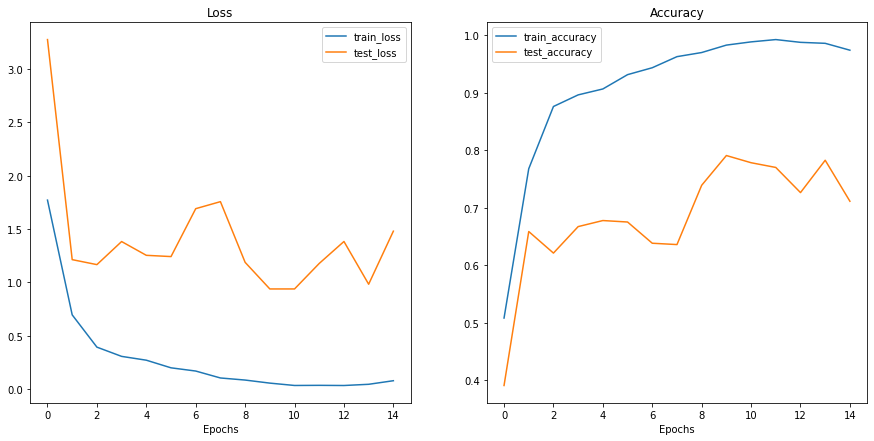

In [21]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://github.com/jfink09/optical-funduscopic-convolutional-neural-network/raw/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [22]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
    
    
    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            #transforms.Grayscale(3),
            #transforms.RandomGrayscale(0.1),
            #transforms.ColorJitter(brightness=.5, hue=.3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ### 

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability 
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);
#pred_and_plot_image(model,'drive/MyDrive/data/train/CRVO/cr1.jpg',class_names)

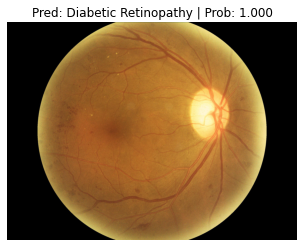

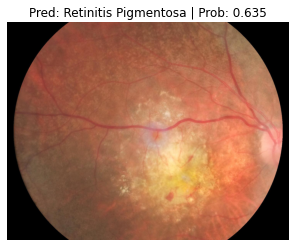

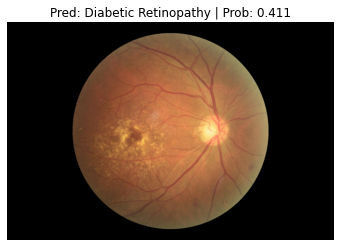

In [23]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data 
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

In [24]:
data_path = Path("data/")
image_path = data_path / "deepfundus"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

Did not find data/deepfundus directory, creating one...


In [25]:
# Import/install Gradio 
try:
    import gradio as gr
except: 
    !pip -q install gradio
    import gradio as gr
    
print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.2/14.2 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 93.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 KB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 KB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
# Put ResNet50 on CPU
model.to("cpu") 

# Check the device
next(iter(model.parameters())).device

device(type='cpu')

In [28]:
# 1. Setup pretrained ResNet50 weights
resnet50_weights = torchvision.models.ResNet50_Weights.DEFAULT

# 2. Get ResNet50 transforms
resnet50_transforms = resnet50_weights.transforms()

# 3. Setup pretrained model
resnet50 = torchvision.models.resnet50(weights=resnet50_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model (this will freeze all layers to begin with)
for param in resnet50.parameters():
    param.requires_grad = True # Set to False for model's other than ResNet

In [29]:
# 5. Update the classifier head
resnet50.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=2048, # keep in_features same 
              out_features=10)) # change out_features to suit our number of classes # 4

In [30]:
def create_resnet50_model(num_classes:int=10, # 4
                          seed:int=42):
    """Creates an ResNet50 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): ResNet50 feature extractor model. 
        transforms (torchvision.transforms): ResNet50 image transforms.
    """
    # 1, 2, 3. Create ResNet50 pretrained weights, transforms and model
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.resnet50(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = True # Set to False for model's other than ResNet

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=2048
                  , out_features=num_classes), # If using EffnetB2 in_features = 1408, EffnetB0 in_features = 1280, if ResNet50 in_features = 2048
    )
    
    return model, transforms

In [31]:
resnet50, resnet50_transforms = create_resnet50_model(num_classes=10, # 4
                                                      seed=42)

In [32]:
from torchinfo import summary

# Print ResNet50 model summary (uncomment for full output) 
summary(resnet50, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 1000]            20,490               True
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      4,096                True
│    │    └─BatchN

In [33]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_resnet50, test_dataloader_resnet50, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=resnet50_transforms,
                                                                                                 batch_size=32)

In [34]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=resnet50.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
#set_seeds()
resnet50_results = engine.train(model=resnet50,
                                train_dataloader=train_dataloader_resnet50,
                                test_dataloader=test_dataloader_resnet50,
                                epochs=15,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.6795 | train_acc: 0.5653 | test_loss: 1.2197 | test_acc: 0.6112
Epoch: 2 | train_loss: 0.6123 | train_acc: 0.8115 | test_loss: 1.0885 | test_acc: 0.6766
Epoch: 3 | train_loss: 0.3646 | train_acc: 0.8804 | test_loss: 1.1021 | test_acc: 0.6825
Epoch: 4 | train_loss: 0.2264 | train_acc: 0.9285 | test_loss: 1.3619 | test_acc: 0.6862
Epoch: 5 | train_loss: 0.1974 | train_acc: 0.9389 | test_loss: 0.8330 | test_acc: 0.7959
Epoch: 6 | train_loss: 0.1162 | train_acc: 0.9655 | test_loss: 0.8669 | test_acc: 0.7846
Epoch: 7 | train_loss: 0.0678 | train_acc: 0.9824 | test_loss: 1.1560 | test_acc: 0.7598
Epoch: 8 | train_loss: 0.0855 | train_acc: 0.9728 | test_loss: 1.2421 | test_acc: 0.7397
Epoch: 9 | train_loss: 0.0888 | train_acc: 0.9671 | test_loss: 1.1405 | test_acc: 0.7272
Epoch: 10 | train_loss: 0.1395 | train_acc: 0.9590 | test_loss: 1.3082 | test_acc: 0.7266
Epoch: 11 | train_loss: 0.1009 | train_acc: 0.9696 | test_loss: 1.2555 | test_acc: 0.7485
Epoch: 12 | train_l

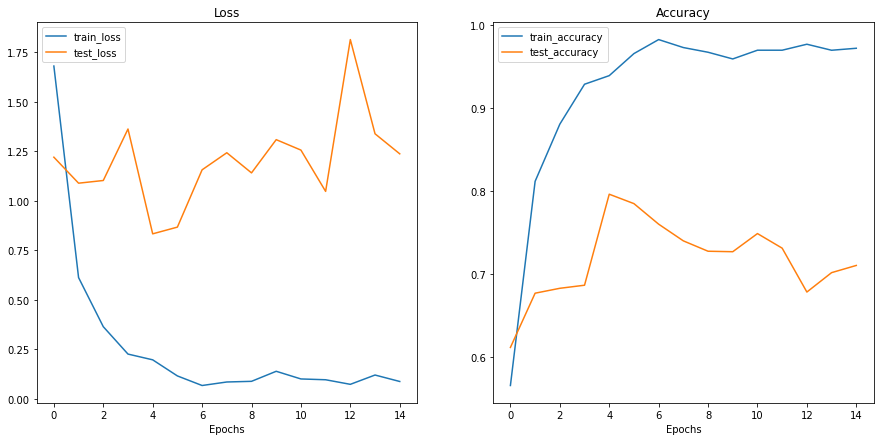

In [35]:
from helper_functions import plot_loss_curves

plot_loss_curves(resnet50_results)

In [36]:
from going_modular.going_modular import utils

# Save the model
utils.save_model(model=resnet50,
                 target_dir="models",
                 model_name="pretrained_resnet50_feature_extractor_drappcompressed.pth")

[INFO] Saving model to: models/pretrained_resnet50_feature_extractor_drappcompressed.pth


In [37]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_resnet50_model_size = Path("models/pretrained_resnet50_feature_extractor_drappcompressed.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ResNet50 feature extractor model size: {pretrained_resnet50_model_size} MB")

Pretrained ResNet50 feature extractor model size: 97 MB


In [38]:
# Count number of parameters in ResNet50
resnet50_total_params = sum(torch.numel(param) for param in resnet50.parameters())
resnet50_total_params

25577522

In [39]:
# Create a dictionary with EffNetB0 statistics
resnet50_stats = {"test_loss": resnet50_results["test_loss"][-1],
                  "test_acc": resnet50_results["test_acc"][-1],
                  "number_of_parameters": resnet50_total_params,
                  "model_size (MB)": pretrained_resnet50_model_size}
resnet50_stats

{'test_loss': 1.236633026599884,
 'test_acc': 0.7100694444444444,
 'number_of_parameters': 25577522,
 'model_size (MB)': 97}

In [40]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: drive/MyDrive/data/test


[PosixPath('drive/MyDrive/data/test/CRVO/cr47.jpg'),
 PosixPath('drive/MyDrive/data/test/CRVO/cr52.jpg'),
 PosixPath('drive/MyDrive/data/test/CRVO/cr49.jpg'),
 PosixPath('drive/MyDrive/data/test/CRVO/cr46.jpg'),
 PosixPath('drive/MyDrive/data/test/CRVO/cr48.jpg')]

In [41]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path], 
                   model: torch.nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaires
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path).convert('RGB')
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list

In [42]:
# Make predictions across test dataset with ResNet50
resnet50_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=resnet50,
                                          transform=resnet50_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU 

  0%|          | 0/314 [00:00<?, ?it/s]

In [43]:
# Inspect the first 2 prediction dictionaries
resnet50_test_pred_dicts[:2]

[{'image_path': PosixPath('drive/MyDrive/data/test/CRVO/cr47.jpg'),
  'class_name': 'CRVO',
  'pred_prob': 0.9942,
  'pred_class': 'Diabetic Retinopathy',
  'time_for_pred': 0.4777,
  'correct': False},
 {'image_path': PosixPath('drive/MyDrive/data/test/CRVO/cr52.jpg'),
  'class_name': 'CRVO',
  'pred_prob': 0.9786,
  'pred_class': 'CRVO',
  'time_for_pred': 0.1575,
  'correct': True}]

In [44]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
resnet50_test_pred_df = pd.DataFrame(resnet50_test_pred_dicts)
resnet50_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,drive/MyDrive/data/test/CRVO/cr47.jpg,CRVO,0.9942,Diabetic Retinopathy,0.4777,False
1,drive/MyDrive/data/test/CRVO/cr52.jpg,CRVO,0.9786,CRVO,0.1575,True
2,drive/MyDrive/data/test/CRVO/cr49.jpg,CRVO,0.8155,Pathological Mypoia,0.2210,False
3,drive/MyDrive/data/test/CRVO/cr46.jpg,CRVO,0.5436,CRVO,0.2263,True
4,drive/MyDrive/data/test/CRVO/cr48.jpg,CRVO,0.9539,CRVO,0.2373,True


In [45]:
# Check number of correct predictions
resnet50_test_pred_df.correct.value_counts()

True     189
False    125
Name: correct, dtype: int64

In [46]:
# Find the average time per prediction 
resnet50_average_time_per_pred = round(resnet50_test_pred_df.time_for_pred.mean(), 4)
print(f"ResNet50 average time per prediction: {resnet50_average_time_per_pred} seconds")

ResNet50 average time per prediction: 0.224 seconds


In [47]:
# Add ResNet50 average prediction time to stats dictionary 
resnet50_stats["time_per_pred_cpu"] = resnet50_average_time_per_pred
resnet50_stats

{'test_loss': 1.236633026599884,
 'test_acc': 0.7100694444444444,
 'number_of_parameters': 25577522,
 'model_size (MB)': 97,
 'time_per_pred_cpu': 0.224}

In [48]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([resnet50_stats])

# Add column for model names
df["model"] = ["ResNet50"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,1.236633,71.01,25577522,97,0.224,ResNet50


In [49]:
# Put ResNet50 on CPU
resnet50.to("cpu") 

# Check the device
next(iter(resnet50.parameters())).device

device(type='cpu')

In [50]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = resnet50_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    resnet50.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(resnet50(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

In [51]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=4)]
example_list

[['drive/MyDrive/data/test/Normal/normal266.jpg'],
 ['drive/MyDrive/data/test/Diabetic Retinopathy/dr277.jpg'],
 ['drive/MyDrive/data/test/Laser Spots/laserspot92.jpg'],
 ['drive/MyDrive/data/test/Pathological Myopia/pm228.jpg']]

In [52]:
import gradio as gr

# Create title, description and article strings
title = "DeepFundus 👀"
description = "A ResNet50 feature extractor computer vision model to classify retina pathology from optical funduscopic images."
article = "Created for fun."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=10, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2451a2a6-d127-4038.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


In [2]:
import shutil
from pathlib import Path

# Create DeepFundus demo path
deepfundus_demo_path = Path("demos/deepfundus/")

# Remove files that might already exist there and create new directory
if deepfundus_demo_path.exists():
    shutil.rmtree(deepfundus_demo_path)
    deepfundus_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    deepfundus_demo_path.mkdir(parents=True, 
                                    exist_ok=True)
    
# Check what's in the folder
!ls demos/deepfundus/

In [3]:
import shutil
from pathlib import Path

# 1. Create an examples directory
deepfundus_examples_path = deepfundus_demo_path / "examples"
deepfundus_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
deepfundus_examples = [Path('drive/MyDrive/data/test/CRVO/cr44.jpg'),
                            Path('drive/MyDrive/data/test/Macular Degeneration/mdegen228.jpg'),
                            Path('drive/MyDrive/data/test/Diabetic Retinopathy/dr240.jpg')]

# 3. Copy the three random images to the examples directory
for example in deepfundus_examples:
    destination = deepfundus_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying drive/MyDrive/data/test/CRVO/cr44.jpg to demos/deepfundus/examples/cr44.jpg
[INFO] Copying drive/MyDrive/data/test/Macular Degeneration/mdegen228.jpg to demos/deepfundus/examples/mdegen228.jpg
[INFO] Copying drive/MyDrive/data/test/Diabetic Retinopathy/dr240.jpg to demos/deepfundus/examples/dr240.jpg


In [4]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(deepfundus_examples_path)]
example_list

[['examples/mdegen228.jpg'], ['examples/dr240.jpg'], ['examples/cr44.jpg']]

In [5]:
import shutil

# Create a source path for our target model
resnet50_deepfundus_model_path = "models/09_pretrained_resnet50_feature_extractor_drappcompressed.pth"

# Create a destination path for our target model 
resnet50_deepfundus_model_destination = deepfundus_demo_path / resnet50_deepfundus_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {resnet50_deepfundus_model_path} to {resnet50_deepfundus_model_destination}")
    
    # Move the model
    shutil.move(src=resnet50_deepfundus_model_path, 
                dst=resnet50_deepfundus_model_destination)
    
    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {resnet50_deepfundus_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {resnet50_deepfundus_model_destination}: {resnet50_deepfundus_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_resnet50_feature_extractor_drappcompressed.pth to demos/deepfundus/09_pretrained_resnet50_feature_extractor_drappcompressed.pth
[INFO] No model found at models/09_pretrained_resnet50_feature_extractor_drappcompressed.pth, perhaps its already been moved?
[INFO] Model exists at demos/deepfundus/09_pretrained_resnet50_feature_extractor_drappcompressed.pth: False


In [6]:
%%writefile demos/deepfundus/model.py
import torch
import torchvision

from torch import nn

def create_resnet50_model(num_classes:int=9, # 4
                          seed:int=42):
    """Creates an ResNet50 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): ResNet50 feature extractor model. 
        transforms (torchvision.transforms): ResNet50 image transforms.
    """
    # 1, 2, 3. Create ResNet50 pretrained weights, transforms and model
    weights = torchvision.models.ResNet50_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.resnet50(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = True # Set to False for model's other than ResNet

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=2048
                  , out_features=num_classes), # If using EffnetB2 in_features = 1408, EffnetB0 in_features = 1280, if ResNet50 in_features = 2048
    )
    
    return model, transforms

Writing demos/deepfundus/model.py


In [8]:
%%writefile demos/deepfundus/app.py
### 1. Imports and class names setup ### 
import gradio as gr
import os
import torch

from model import create_resnet50_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['CRVO',
  'Choroidal Nevus',
  'Diabetic Retinopathy',
  'Laser Spots',
  'Macular Degeneration',
  'Macular Hole',
  'Myelinated Nerve Fiber',
  'Normal',
  'Pathological Mypoia',
  'Retinitis Pigmentosa']

### 2. Model and transforms preparation ###

# Create ResNet50 model
resnet50, resnet50_transforms = create_resnet50_model(
    num_classes=len(class_names), # actual value would also work
)

# Load saved weights
resnet50.load_state_dict(
    torch.load(
        f="pretrained_resnet50_feature_extractor_drappcompressed.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()
    
    # Transform the target image and add a batch dimension
    img = resnet50_transforms(img).unsqueeze(0)
    
    # Put model into evaluation mode and turn on inference mode
    resnet50.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(resnet50(img), dim=1)
    
    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}
    
    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)
    
    # Return the prediction dictionary and prediction time 
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "DeepFundus 👀"
description = "A ResNet50 feature extractor computer vision model to classify funduscopic images."
article = "Created with the help from [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=10, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list, 
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Overwriting demos/deepfundus/app.py


In [59]:
%%writefile demos/deepfundus/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/deepfundus/requirements.txt


In [60]:
!ls demos/deepfundus

app.py	examples  model.py  requirements.txt


In [61]:
# Change into and then zip the deepfundus folder but exclude certain files
!cd demos/deepfundus && zip -r ../deepfundus.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped DeepFundus app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/deepfundus.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: app.py (deflated 56%)
  adding: examples/ (stored 0%)
  adding: examples/mdegen228.jpg (deflated 20%)
  adding: examples/dr240.jpg (deflated 28%)
  adding: examples/cr44.jpg (deflated 11%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>